In [462]:
# Import libraries
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
import requests
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

In [463]:
# Override how Pandas Datareader reads data
yf.pdr_override()

In [464]:
today = datetime.now()
start = datetime(today.year - 1, today.month-1, today.day+3)
end = datetime(today.year, today.month-1, today.day-1)
print(start)
print(end)

2023-04-10 00:00:00
2024-04-06 00:00:00


In [465]:
# Data acquisition from YahooFinance
stock = "ZOMATO.NS"
today = datetime.now()
start = datetime(today.year - 1, today.month-1, today.day+3)
end = datetime(today.year, today.month-1, today.day-1)
print(start)
print(end)

df = yf.download(stock, start, end)

df.head()

[*********************100%%**********************]  1 of 1 completed

2023-04-10 00:00:00
2024-04-06 00:00:00


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-04-10,52.150002,54.200001,51.799999,53.950001,53.950001,60655412
2023-04-11,54.650002,55.250000,53.250000,53.950001,53.950001,41101417
2023-04-12,54.250000,54.250000,52.900002,53.200001,53.200001,30848068
2023-04-13,53.200001,54.150002,52.849998,53.849998,53.849998,26646279
2023-04-17,54.200001,54.250000,53.000000,53.950001,53.950001,24787918


In [466]:
# Ticker for searching news
stockraw = stock[:-3]

stockraw

'ZOMATO'

In [467]:
# Getting data using html requests
link = f"https://news.google.com/search?q={stockraw}&hl=en-IN&gl=IN&ceid=IN%3Aen"
req = Request(link, headers={'User-Agent': 'Mozilla/5.0'})
webpage = urlopen(req).read()
print(webpage)

b'<!doctype html><html lang="en-IN" dir="ltr"><head><base href="https://news.google.com/"><link ref="preconnect" href="//www.gstatic.com"><meta name="referrer" content="origin"><link rel="canonical" href="https://news.google.com/search"><meta name="viewport" content="width=device-width,initial-scale=1,minimal-ui"><meta name="google-site-verification" content="AcBy5YFny2HQgVUCR18tO5YUTf6MpVlcJqGTd-a9-SI"><meta name="mobile-web-app-capable" content="yes"><meta name="apple-mobile-web-app-capable" content="yes"><meta name="application-name" content="News"><meta name="apple-mobile-web-app-title" content="News"><meta name="apple-mobile-web-app-status-bar-style" content="black"><meta name="theme-color" content="white"><meta name="msapplication-tap-highlight" content="no"><link rel="shortcut icon" href="https://lh3.googleusercontent.com/-DR60l-K8vnyi99NZovm9HlXyZwQ85GMDxiwJWzoasZYCUrPuUM_P_4Rb7ei03j-0nRs0c4F=w16" sizes="16x16"><link rel="shortcut icon" href="https://lh3.googleusercontent.com/-

In [468]:
# Extracting headlines and the dates when they were published to find sentiments
with requests.Session() as c:
    soup = BeautifulSoup(webpage, 'html.parser')

    # Extract titles and datetimes simultaneously
    titles = soup.find_all('a', class_='JtKRv')
    datetimes = soup.find_all('time', class_='hvbAAd')

    # Create lists to store extracted data
    dates_list = []
    titles_list = []

    for title, datetime_tag in zip(titles, datetimes):
        title_text = title.text.strip()  # Remove leading/trailing whitespace from title
        datetime_str = datetime_tag['datetime']
        formatted_datetime = datetime.strptime(datetime_str, '%Y-%m-%dT%H:%M:%S%z')  # Parse datetime string

        # Append data to respective lists
        dates_list.append(formatted_datetime.date())
        titles_list.append(title_text)

    # Create DataFrame
    df2 = pd.DataFrame({'Date': dates_list, 'Headline': titles_list})

    # Print DataFrame
    print(df2)

          Date                                           Headline
0   2024-05-07  Zomato share price Today Live Updates : Zomato...
1   2024-05-06  BoB, Zomato, Coal India, BHEL and PFC | Stocks...
2   2024-05-06  Zomato launches 'shake it to make it' feature ...
3   2024-05-07  Zomato introduces 'shake to earn' feature offe...
4   2024-05-06  Chartist talks: REC, PFC look overbought, but ...
..         ...                                                ...
92  2024-03-26  Technical Breakout Stocks: How to trade IndiGo...
93  2024-04-05  Zomato shares zoom to an all-time high near Rs...
94  2024-02-15  Zomato share price hits 52-week high, up 225% ...
95  2024-03-21  Social media backlash forces Zomato to drop ‘g...
96  2024-03-29  Zomato delivery partner sobs inconsolably, ask...

[97 rows x 2 columns]


In [469]:
# Loading the tokenizer to generate tokens and model to perform sentiment analysis
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')

In [470]:
# Finding the encodings for each of the headlines found
encoded_headlines = []
for headline in df2['Headline']:
    encoded_headline = tokenizer(headline, padding=True, truncation=True, return_tensors='pt')
    encoded_headlines.append(encoded_headline)
print(encoded_headlines)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[{'input_ids': tensor([[    0,  1301,  1075,  3938,   458,   425,  2477,  3561, 24677,  4832,
           525,  1075,  3938,  1367,   452,    23, 14333,  9264,  9253, 31080,
             4,  3506,     6,   159,   111,   176,     4,  3546,   207,    31,
          2350,    18, 14333,  9264,  9253, 23688,     4,  2545,  1721, 20128,
             2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}, {'input_ids': tensor([[    0, 18935,   387,     6,   525,  1075,  3938,     6, 17801,   666,
             6,   163,   725,  3721,     8,   221,  5268,  1721,   312,  6368,
            14,   189,  2364,    62,     7,   508,    12,   996,   207,    11,
             5,   765,  1385,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}, {'input_ids': tensor([[    0,  1301,  1075,  3938, 101

In [471]:
# Finding the sentiment scores of each headline
# Initialize an empty list to store the tweet sentiments
headline_sentiments = []

# Iterate over the encoded tweets
for encoded_headline in encoded_headlines:
    # Pass the encoded tweet to the model
    output = model(**encoded_headline)

    # Extract the scores
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    # Calculate the sentiment score between -1 and 1
    sentiment_score = scores[2] - scores[0]  # Assuming 'labels' are ordered as [negative, neutral, positive]

    # Append the sentiment score to the list
    headline_sentiments.append(sentiment_score)

# Print the tweet sentiments
for i in headline_sentiments:
    print(i)

-0.11899917
0.62003124
0.5327543
0.53684765
-0.41061825
0.07071741
0.008811604
0.20217913
-0.32669088
-0.4166874
-0.071587294
-0.42514744
0.1775506
0.2743201
0.85012877
0.5946534
0.8075013
0.619064
0.12294003
-0.21452531
0.19665387
-0.0039010532
0.15609673
0.07961612
0.010933474
0.074866876
-0.2890502
0.035706878
0.56018704
-0.220135
-0.015972309
-0.7306267
0.16521098
0.2964714
0.40027118
0.14745624
0.87021816
-0.07449117
-0.9114541
-0.055294547
0.4113418
-0.047414348
0.07532421
-0.3227219
-0.051363464
0.22586027
0.8733867
0.00391626
-0.02010148
-0.47445124
0.92076874
-0.014625914
-0.3150021
0.15471818
0.031742785
0.051330943
-0.4064017
0.113875374
-0.022028923
-0.15766802
-0.6030687
0.22943404
-0.033256046
0.29670542
-0.08481279
0.23006766
-0.11843405
0.0348925
-0.031084023
0.8318809
-0.48607227
0.32851002
0.18335068
-0.90082765
0.33565506
-0.24103391
0.53962207
0.31023535
-0.0076246224
-0.34275523
-0.30107963
0.07417288
0.013660129
-0.010265764
0.09034082
0.60086083
-0.27237335
0.129

In [472]:
# Add the tweet sentiments as a new column to the DataFrame
df2['Sentiments'] = headline_sentiments

# Print the DataFrame with the added column
print(df2)

          Date                                           Headline  Sentiments
0   2024-05-07  Zomato share price Today Live Updates : Zomato...   -0.118999
1   2024-05-06  BoB, Zomato, Coal India, BHEL and PFC | Stocks...    0.620031
2   2024-05-06  Zomato launches 'shake it to make it' feature ...    0.532754
3   2024-05-07  Zomato introduces 'shake to earn' feature offe...    0.536848
4   2024-05-06  Chartist talks: REC, PFC look overbought, but ...   -0.410618
..         ...                                                ...         ...
92  2024-03-26  Technical Breakout Stocks: How to trade IndiGo...    0.003679
93  2024-04-05  Zomato shares zoom to an all-time high near Rs...    0.695185
94  2024-02-15  Zomato share price hits 52-week high, up 225% ...    0.741556
95  2024-03-21  Social media backlash forces Zomato to drop ‘g...   -0.533301
96  2024-03-29  Zomato delivery partner sobs inconsolably, ask...   -0.842057

[97 rows x 3 columns]


In [473]:
# Convert 'Date' column to datetime if it's not already
df2['Date'] = pd.to_datetime(df2['Date'])

# Group by 'Date' and calculate the average sentiment for each day
average_sentiments = df2.groupby('Date')['Sentiments'].mean().reset_index()

# Print the DataFrame with one row per date and the average sentiment for each day
print(average_sentiments)

         Date  Sentiments
0  2024-02-08   -0.010266
1  2024-02-09    0.831881
2  2024-02-12   -0.406402
3  2024-02-15    0.741556
4  2024-03-05   -0.007625
5  2024-03-06   -0.299445
6  2024-03-07    0.183351
7  2024-03-09   -0.094992
8  2024-03-11   -0.342755
9  2024-03-16   -0.272373
10 2024-03-17   -0.536586
11 2024-03-18    0.628212
12 2024-03-19    0.201091
13 2024-03-20    0.021802
14 2024-03-21   -0.055999
15 2024-03-22   -0.342078
16 2024-03-23   -0.084813
17 2024-03-26    0.003679
18 2024-03-27    0.585755
19 2024-03-28   -0.034110
20 2024-03-29   -0.842057
21 2024-03-30   -0.051363
22 2024-03-31   -0.047414
23 2024-04-01   -0.198073
24 2024-04-02   -0.103191
25 2024-04-03    0.400271
26 2024-04-05    0.387401
27 2024-04-08    0.310235
28 2024-04-09   -0.900828
29 2024-04-12    0.465221
30 2024-04-16    0.176375
31 2024-04-20    0.003916
32 2024-04-22    0.734596
33 2024-04-25    0.274320
34 2024-04-26    0.065977
35 2024-04-27    0.075324
36 2024-04-28   -0.326691
37 2024-04-2

In [474]:
print(average_sentiments.index.dtype)

int64


In [475]:
# Merge the dataframes on the 'Date' column with a left join to keep all rows from df
merged_df = pd.merge(df, average_sentiments, on='Date', how='left')

# Fill missing sentiment scores with 0
merged_df['Sentiments'].fillna(0, inplace=True)

# If you want to ensure that 'Sentiments' column is of numeric type
merged_df['Sentiments'] = pd.to_numeric(merged_df['Sentiments'])

# If you want to overwrite the 'Sentiments' column with 0 where there's no match
# merged_df['Sentiments'].fillna(0, inplace=True)

merged_df.tail(20)

,Date,Open,High,Low,Close,Adj Close,Volume,Sentiments
225,2024-03-06,164.399994,164.399994,157.500000,161.550003,161.550003,95621548,-0.299445
226,2024-03-07,161.750000,163.449997,158.649994,160.000000,160.000000,43685238,0.183351
227,2024-03-11,161.000000,163.199997,149.000000,154.850006,154.850006,51519591,-0.342755
228,2024-03-12,156.600006,157.899994,152.149994,156.899994,156.899994,31159766,0.000000
229,2024-03-13,157.449997,158.250000,147.500000,148.649994,148.649994,53202095,0.000000
230,2024-03-14,147.100006,157.300003,144.300003,152.750000,152.750000,45708365,0.000000
231,2024-03-15,152.850006,161.699997,152.449997,160.050003,160.050003,95085427,0.000000
232,2024-03-18,162.500000,164.449997,157.250000,158.250000,158.250000,35382756,0.628212
233,2024-03-19,158.600006,161.449997,156.500000,157.949997,157.949997,24847687,0.201091
234,2024-03-20,159.449997,166.699997,159.000000,165.600006,165.600006,45544054,0.021802


In [476]:
print(merged_df.index.dtype)

int64


In [477]:
#Adding an index column to the dataframe
#merged_df.reset_index(inplace=True)
#merged_df['Index'] = df.index + 1

#merged_df.head()

In [478]:
# Isolating dates to plot graphs more conveniently
train_dates = pd.to_datetime(merged_df['Date'])

print(train_dates)

0     2023-04-10
1     2023-04-11
2     2023-04-12
3     2023-04-13
4     2023-04-17
         ...    
240   2024-04-01
241   2024-04-02
242   2024-04-03
243   2024-04-04
244   2024-04-05
Name: Date, Length: 245, dtype: datetime64[ns]


In [479]:
# Isolate variables for training
cols = list(merged_df)[1:8]
print(cols)
cols2 = list(merged_df)[1:7]
print(cols2)
cols3 = list(merged_df)[1:6]
print(cols3)

['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Sentiments']
['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
['Open', 'High', 'Low', 'Close', 'Adj Close']


<Axes: >

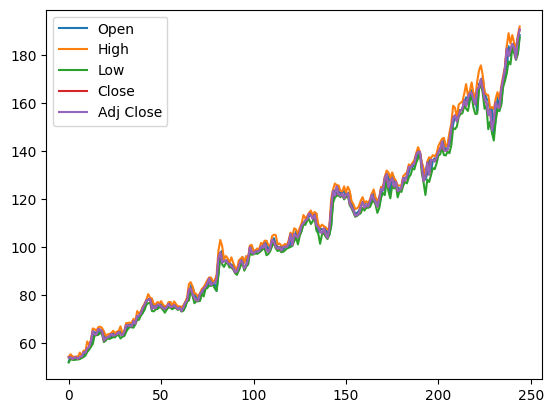

In [480]:
# Displaying Open, High, Low, Close and Adjusted Closing price
df_for_display = merged_df[cols3].astype(float)
df_for_display.plot.line()

<Axes: >

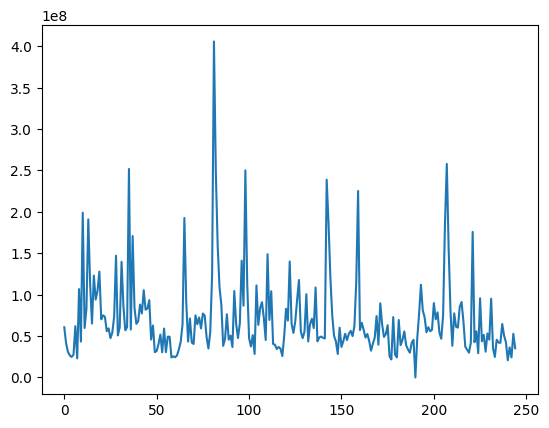

In [481]:
# Displaying traded Volume
df_for_display = merged_df['Volume'].astype(float)
df_for_display.plot.line()

<Axes: >

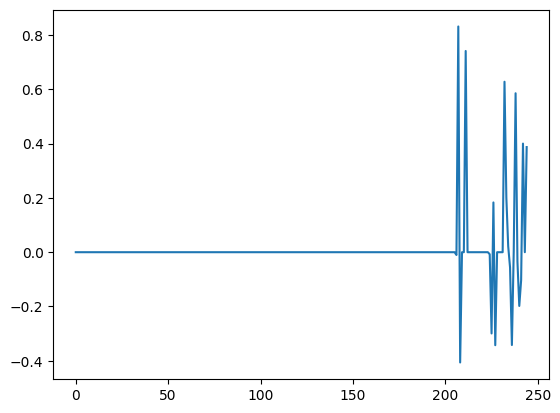

In [482]:
# Displaying Sentiments
df_for_display = merged_df['Sentiments'].astype(float)
df_for_display.plot.line()

In [483]:
# Storing all data to be fed to the modl
df_for_training = df[cols3].astype(float)

In [484]:
# Scaling data
scaler = MinMaxScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

print(df_for_training_scaled)

[[0.00000000e+00 3.63234555e-04 0.00000000e+00 5.46249093e-03
  5.46249093e-03]
 [1.83688466e-02 7.99127106e-03 1.07050628e-02 5.46249093e-03
  5.46249093e-03]
 [1.54298200e-02 7.26469110e-04 8.12109474e-03 0.00000000e+00
  0.00000000e+00]
 ...
 [9.53710484e-01 9.28804919e-01 9.30601743e-01 9.11143503e-01
  9.11143503e-01]
 [9.43056575e-01 9.73483406e-01 9.48320414e-01 9.74508376e-01
  9.74508376e-01]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00]]


In [485]:
# Empty lists to be populated with formatted training data
trainX = []
trainY = []

In [486]:
# Creating sequences
n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (231, 14, 5).
trainY shape == (231, 1).


In [487]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 14, 64)            17920     
                                                                 
 lstm_19 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30369 (118.63 KB)
Trainable params: 30369 (118.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/5
13/13 [==============================] - 8s 103ms/step - loss: 0.1547 - val_loss: 0.3079
Epoch 2/5
13/13 [==============================] - 0s 27ms/step - loss: 0.0407 - val_loss: 0.0587
Epoch 3/5
13/13 [==============================] - 0s 26ms/step - loss: 0.0173 - val_loss: 0.0051
Epoch 4/5
13/13 [==============================] - 0s 21ms/step - loss: 0.0207 - val_loss: 0.0066
Epoch 5/5
13/13 [==============================] - 0s 16ms/step - loss: 0.0136 - val_loss: 0.0185


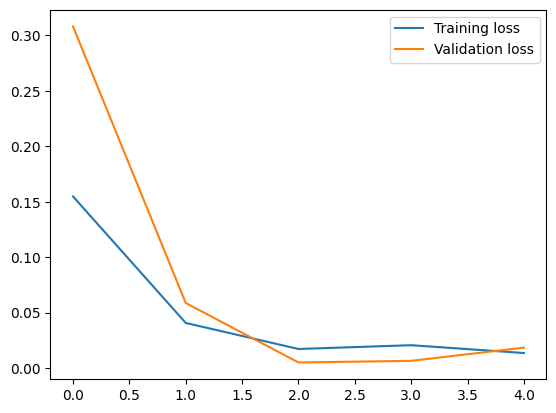

In [488]:
# Fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [489]:
# To account for holidays like weekends (couldn't find one for India)
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
n_past = 16
n_days_for_prediction=30
predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()

In [490]:
# Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

1/1 [==============================] - 0s 297ms/step


In [491]:
# Perform inverse transformation
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

In [492]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

<ipython-input-493-94fac0d4ce40>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


<Axes: xlabel='Date', ylabel='Open'>

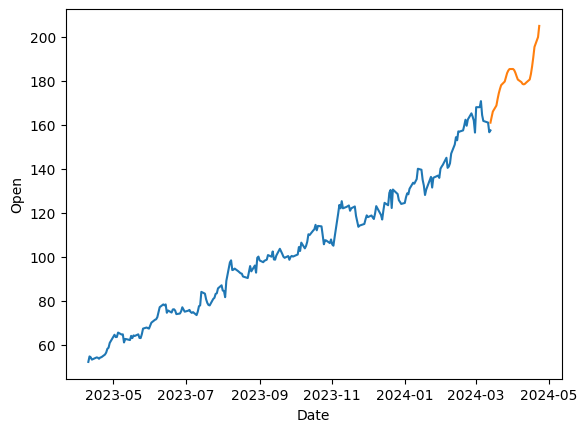

In [493]:
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


original = merged_df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= start]

# Plot the dataframes using separate x and y values
original = original.iloc[:-15]

sns.lineplot(data=original, x="Date", y="Open")
sns.lineplot(data=df_forecast, x="Date", y="Open")

<ipython-input-494-3bb337b27e21>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


<Axes: xlabel='Date', ylabel='Open'>

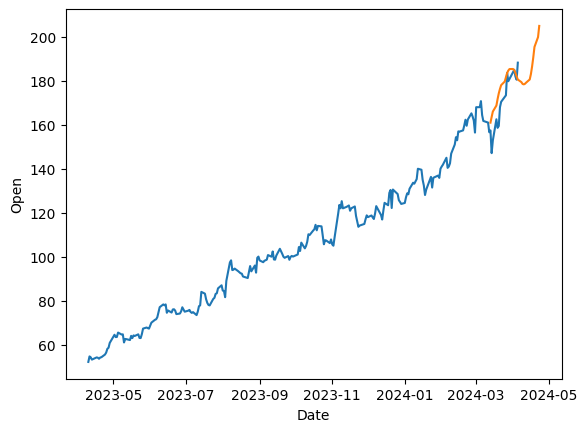

In [494]:
original = merged_df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']

# Plot the dataframes using separate x and y values
sns.lineplot(data=original, x="Date", y="Open")
sns.lineplot(data=df_forecast, x="Date", y="Open")

In [501]:
# Merge the dataframes on the 'Date' column
merged_data = pd.merge(original, df_forecast, on='Date', how='inner')

# Calculate the standard deviation of the 'Open' prices
std_dev = merged_data['Open_x'].std()

print("Standard Deviation of Open Prices:", std_dev)

Standard Deviation of Open Prices: 13.075153146386098
